# Part 1: Time-of-Purchase Window Analysis for BTC Accumulation

This notebook explores **optimal purchase timing** for Bitcoin DCA (Dollar-Cost Averaging) strategies across **12-month rolling windows**.

**Goal:** Determine whether varying the *frequency* (daily, weekly, biweekly) or *timing* (weekday, month, day-of-month) of purchases can improve accumulation efficiency under a fixed budget.

**Sections:**
1. Setup & data loading
2. DCA simulation engine
3. Daily vs weekly vs biweekly comparison (rolling 12-month windows)
4. Weekday buy-day effects
5. Monthly seasonality
6. Day-of-month effects
7. Weekday × Month interaction heatmap
8. Statistical significance testing
9. Strategy comparison dashboard

This notebook is **self-contained** — it does not depend on `eda_starter_template.py`.

## 1. Setup and Configuration

In [1]:
from __future__ import annotations

from datetime import date, timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import polars as pl
import seaborn as sns
from scipy import stats

# --- Plot style ---
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# --- Paths (self-contained; no dependency on eda_starter_template) ---
NOTEBOOK_DIR = Path.cwd()
# Handle running from either eda/ or project root
if NOTEBOOK_DIR.name == "eda":
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

DATA_DIR = PROJECT_ROOT / "data"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
PLOTS_DIR = PROJECT_ROOT / "eda" / "plots"
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

# --- DCA budget ---
BUY_AMOUNT_USD = 10.0  # Fixed USD per purchase event

print(f"Project root : {PROJECT_ROOT}")
print(f"Data file    : {COINMETRICS_PATH}")
print(f"Plots dir    : {PLOTS_DIR}")
print(f"Buy amount   : ${BUY_AMOUNT_USD} per event")

Project root : c:\Users\tsivakumar\Projects\OMSA
Data file    : c:\Users\tsivakumar\Projects\OMSA\data\Coin Metrics\coinmetrics_btc.csv
Plots dir    : c:\Users\tsivakumar\Projects\OMSA\eda\plots
Buy amount   : $10.0 per event


## 2. Load Bitcoin Price Data

Load the Coin Metrics CSV via Polars lazy scan, parse the `time` column as a date, keep only rows with a valid `PriceUSD`, and sort chronologically.

In [2]:
raw = (
    pl.scan_csv(str(COINMETRICS_PATH), infer_schema_length=10000)
    .with_columns(pl.col("time").str.strptime(pl.Date, "%Y-%m-%d").alias("date"))
    .select(["date", "PriceUSD"])
    .filter(pl.col("PriceUSD").is_not_null())
    .sort("date")
    .collect()
)

print(f"Loaded {len(raw):,} rows  |  {raw['date'].min()} → {raw['date'].max()}")
raw.head(5)

Loaded 5,659 rows  |  2010-07-18 → 2026-01-13


date,PriceUSD
date,f64
2010-07-18,0.08584
2010-07-19,0.0808
2010-07-20,0.074736
2010-07-21,0.079193
2010-07-22,0.05847


## 3. Data Preprocessing & Date Feature Engineering

Add calendar features for downstream grouping: weekday, month, day-of-month, year, week-of-year. Also compute daily log-returns.

In [3]:
btc = raw.with_columns([
    pl.col("date").dt.weekday().alias("weekday"),        # 1=Mon .. 7=Sun (ISO)
    pl.col("date").dt.month().alias("month"),
    pl.col("date").dt.year().alias("year"),
    pl.col("date").dt.day().alias("day_of_month"),
    pl.col("date").dt.week().alias("week_of_year"),
    (pl.col("PriceUSD") / pl.col("PriceUSD").shift(1) - 1).alias("daily_return"),
    (pl.col("PriceUSD") / pl.col("PriceUSD").shift(1)).log().alias("log_return"),
])

WEEKDAY_LABELS = {1: "Mon", 2: "Tue", 3: "Wed", 4: "Thu", 5: "Fri", 6: "Sat", 7: "Sun"}
MONTH_LABELS = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

print(f"Features added. Shape: {btc.shape}")
btc.head(5)

Features added. Shape: (5659, 9)


date,PriceUSD,weekday,month,year,day_of_month,week_of_year,daily_return,log_return
date,f64,i8,i8,i32,i8,i8,f64,f64
2010-07-18,0.08584,7,7,2010,18,28,null,null
2010-07-19,0.0808,1,7,2010,19,29,-0.058714,-0.060508
2010-07-20,0.074736,2,7,2010,20,29,-0.075053,-0.078019
2010-07-21,0.079193,3,7,2010,21,29,0.059639,0.057928
2010-07-22,0.05847,4,7,2010,22,29,-0.261679,-0.303376


## 4. DCA Strategy Simulator

A reusable function that invests a fixed USD amount on every eligible buy-date within a 12-month window.

**Frequencies:**
- **Daily**: buy every trading day
- **Weekly**: buy once per week on a specified weekday
- **Biweekly**: buy every other week on a specified weekday

Returns performance metrics: total BTC accumulated, average cost basis, final portfolio value, and ROI.

In [4]:
def simulate_dca(
    prices: pl.DataFrame,
    start_date: date,
    end_date: date,
    frequency: str = "daily",
    buy_weekday: int | None = None,  # ISO weekday 1=Mon..7=Sun (used for weekly/biweekly)
) -> dict | None:
    """Simulate fixed-budget DCA over the given date range.

    Parameters
    ----------
    prices : pl.DataFrame with columns ["date", "PriceUSD", "weekday"]
    start_date, end_date : inclusive window bounds
    frequency : "daily" | "weekly" | "biweekly"
    buy_weekday : ISO weekday for weekly/biweekly (default 1 = Monday)

    Returns
    -------
    dict of performance metrics, or None if no valid purchases.
    """
    if buy_weekday is None:
        buy_weekday = 1  # Monday

    window = prices.filter(
        (pl.col("date") >= start_date) & (pl.col("date") <= end_date)
    ).sort("date")

    if len(window) == 0:
        return None

    dates_list = window["date"].to_list()
    prices_list = window["PriceUSD"].to_list()
    weekdays_list = window["weekday"].to_list()

    total_spent = 0.0
    btc_accumulated = 0.0
    num_buys = 0
    buy_count = 0  # counter for biweekly toggle

    for i, (d, price, wd) in enumerate(zip(dates_list, prices_list, weekdays_list)):
        if price is None or price <= 0:
            continue

        buy = False
        if frequency == "daily":
            buy = True
        elif frequency == "weekly":
            buy = (wd == buy_weekday)
        elif frequency == "biweekly":
            if wd == buy_weekday:
                buy_count += 1
                buy = (buy_count % 2 == 1)  # every other occurrence

        if buy:
            btc_accumulated += BUY_AMOUNT_USD / price
            total_spent += BUY_AMOUNT_USD
            num_buys += 1

    if total_spent == 0:
        return None

    avg_cost = total_spent / btc_accumulated
    final_price = prices_list[-1] if prices_list[-1] and prices_list[-1] > 0 else avg_cost
    final_value = btc_accumulated * final_price
    roi_pct = (final_value / total_spent - 1) * 100

    return {
        "window_start": start_date,
        "window_end": end_date,
        "frequency": frequency,
        "buy_weekday": buy_weekday,
        "total_spent": total_spent,
        "total_btc": btc_accumulated,
        "avg_cost": avg_cost,
        "final_price": final_price,
        "final_value": final_value,
        "roi_pct": roi_pct,
        "num_buys": num_buys,
    }

print("DCA simulator ready.")

DCA simulator ready.


## 5. Rolling 12-Month DCA Comparison: Daily vs Weekly vs Biweekly

Generate all rolling 12-month windows (sliding by 1 month). For each window run daily, weekly (Monday), and biweekly (every-other Monday) DCA simulations.

In [5]:
def generate_rolling_windows(
    min_date: date, max_date: date, window_months: int = 12, step_months: int = 1
) -> list[tuple[date, date]]:
    """Return (start, end) pairs for rolling windows."""
    windows = []
    d = min_date
    while True:
        end_year = d.year + (d.month + window_months - 1) // 12
        end_month = (d.month + window_months - 1) % 12 + 1
        end_d = date(end_year, end_month, min(d.day, 28))
        if end_d > max_date:
            break
        windows.append((d, end_d))
        # step forward
        step_year = d.year + (d.month + step_months - 1) // 12
        step_month = (d.month + step_months - 1) % 12 + 1
        d = date(step_year, step_month, min(d.day, 28))
    return windows


all_dates = btc["date"].to_list()
windows = generate_rolling_windows(all_dates[0], all_dates[-1], window_months=12, step_months=1)
print(f"Generated {len(windows)} rolling 12-month windows")
print(f"First: {windows[0]}  |  Last: {windows[-1]}")

# --- Run simulations ---
results = []
for start, end in windows:
    for freq in ["daily", "weekly", "biweekly"]:
        r = simulate_dca(btc, start, end, frequency=freq, buy_weekday=1)
        if r:
            results.append(r)

results_df = pl.DataFrame(results)
print(f"\nSimulated {len(results_df):,} strategy-windows")
results_df.head(6)

Generated 174 rolling 12-month windows
First: (datetime.date(2010, 7, 18), datetime.date(2011, 7, 18))  |  Last: (datetime.date(2024, 12, 18), datetime.date(2025, 12, 18))

Simulated 522 strategy-windows


window_start,window_end,frequency,buy_weekday,total_spent,total_btc,avg_cost,final_price,final_value,roi_pct,num_buys
date,date,str,i64,f64,f64,f64,f64,f64,f64,i64
2010-07-18,2011-07-18,"""daily""",1,3660.0,19462.52052,0.188054,13.630521,265284.299541,7148.204905,366
2010-07-18,2011-07-18,"""weekly""",1,530.0,2816.255779,0.188193,13.630521,38387.034244,7142.83665,53
2010-07-18,2011-07-18,"""biweekly""",1,270.0,1410.722132,0.191391,13.630521,19228.877996,7021.806665,27
2010-08-18,2011-08-18,"""daily""",1,3660.0,14644.039122,0.249931,10.858471,159011.8808,4244.586907,366
2010-08-18,2011-08-18,"""weekly""",1,520.0,2056.203317,0.252893,10.858471,22327.225029,4193.697121,52
2010-08-18,2011-08-18,"""biweekly""",1,260.0,1086.915466,0.239209,10.858471,11802.240567,4439.323295,26


## 6. Compare DCA Frequency Performance Metrics

Visualise ROI distributions, average cost basis, and sats-per-dollar across all rolling 12-month windows for each frequency.

C:\Users\tsivakumar\AppData\Local\Temp\1\ipykernel_71488\1109855211.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x="frequency", y="roi_pct", order=freq_order, ax=axes[0], palette="Set2")


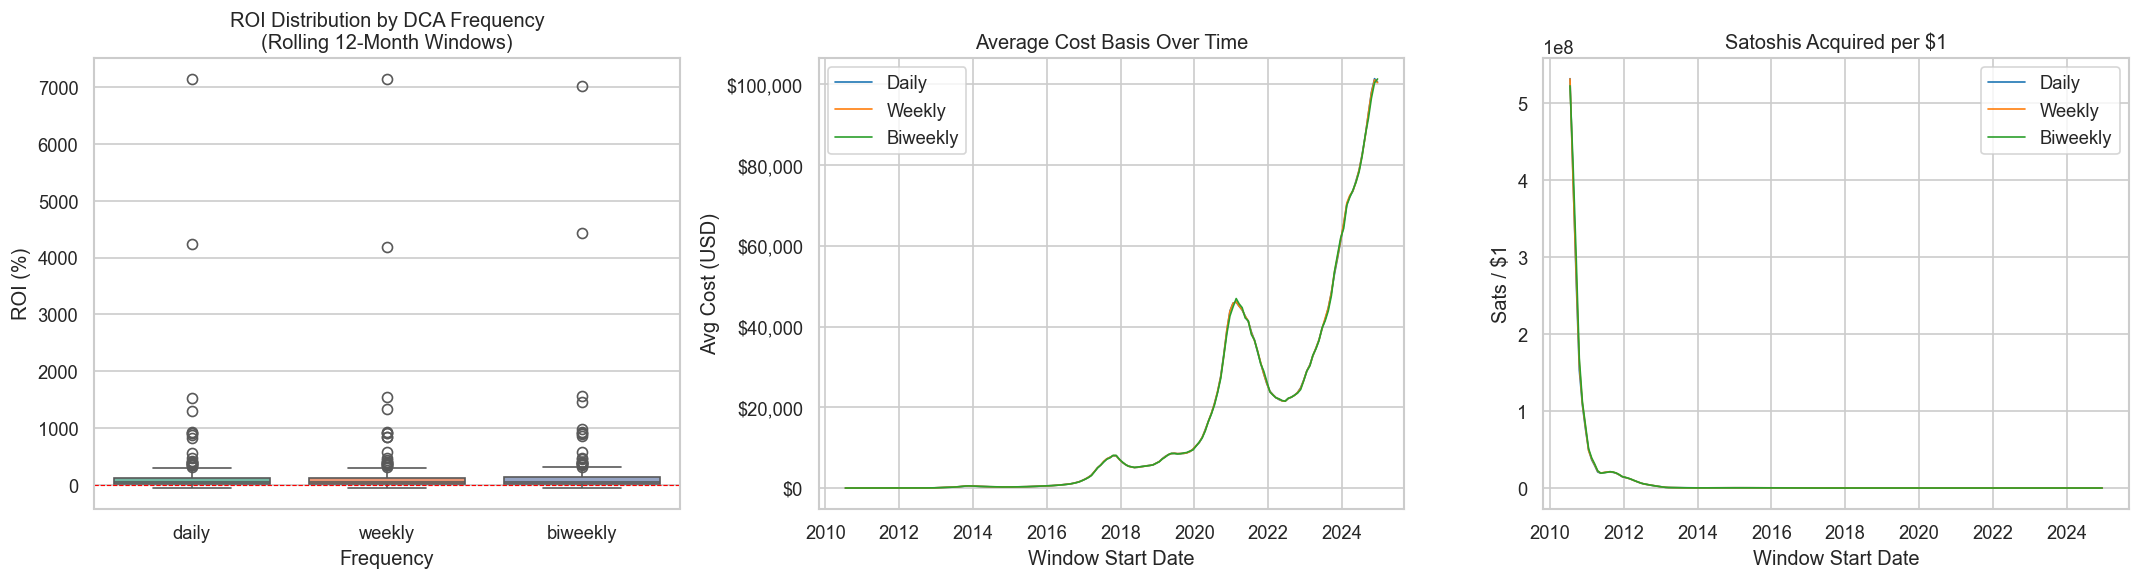

Saved dca_cadence_comparison.png


In [6]:
pdf = results_df.to_pandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- A: ROI distribution by frequency ---
freq_order = ["daily", "weekly", "biweekly"]
sns.boxplot(data=pdf, x="frequency", y="roi_pct", order=freq_order, ax=axes[0], palette="Set2")
axes[0].set_title("ROI Distribution by DCA Frequency\n(Rolling 12-Month Windows)")
axes[0].set_ylabel("ROI (%)")
axes[0].set_xlabel("Frequency")
axes[0].axhline(0, color="red", linestyle="--", linewidth=0.7)

# --- B: Average cost basis over time ---
for freq, color in zip(freq_order, ["#1f77b4", "#ff7f0e", "#2ca02c"]):
    subset = pdf[pdf["frequency"] == freq]
    axes[1].plot(subset["window_start"], subset["avg_cost"], label=freq.title(), color=color, linewidth=1)
axes[1].set_title("Average Cost Basis Over Time")
axes[1].set_xlabel("Window Start Date")
axes[1].set_ylabel("Avg Cost (USD)")
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
axes[1].legend()

# --- C: Sats per $1 ---
for freq, color in zip(freq_order, ["#1f77b4", "#ff7f0e", "#2ca02c"]):
    subset = pdf[pdf["frequency"] == freq]
    axes[2].plot(subset["window_start"], 1e8 / subset["avg_cost"], label=freq.title(), color=color, linewidth=1)
axes[2].set_title("Satoshis Acquired per $1")
axes[2].set_xlabel("Window Start Date")
axes[2].set_ylabel("Sats / $1")
axes[2].legend()

plt.tight_layout()
plt.savefig(PLOTS_DIR / "dca_cadence_comparison.png", bbox_inches="tight")
plt.show()
print("Saved dca_cadence_comparison.png")

In [7]:
# Summary statistics table
freq_summary = (
    results_df
    .group_by("frequency")
    .agg([
        pl.col("roi_pct").mean().alias("mean_roi"),
        pl.col("roi_pct").median().alias("median_roi"),
        pl.col("roi_pct").std().alias("std_roi"),
        pl.col("roi_pct").min().alias("worst_roi"),
        pl.col("roi_pct").max().alias("best_roi"),
        pl.col("avg_cost").mean().alias("mean_avg_cost"),
        pl.col("avg_cost").median().alias("median_avg_cost"),
        pl.col("num_buys").mean().alias("mean_buys"),
    ])
    .sort("mean_roi", descending=True)
)
print("DCA Frequency Summary (across all rolling 12-month windows):")
freq_summary

DCA Frequency Summary (across all rolling 12-month windows):


frequency,mean_roi,median_roi,std_roi,worst_roi,best_roi,mean_avg_cost,median_avg_cost,mean_buys
str,f64,f64,f64,f64,f64,f64,f64,f64
"""biweekly""",184.983191,44.984546,659.576304,-55.248101,7021.806665,15891.437547,5305.671954,26.33908
"""weekly""",181.032173,44.024436,655.545713,-54.498727,7142.83665,15952.214651,5308.771233,52.33908
"""daily""",180.681099,44.117233,657.056162,-53.913957,7148.204905,15944.097715,5330.124831,366.275862


## 7. Analyze Buy-Day-of-Week Effects

For weekly DCA over all rolling 12-month windows, simulate buying on **each individual weekday** (Mon–Sun). This reveals whether any particular day of the week consistently yields a lower average cost.

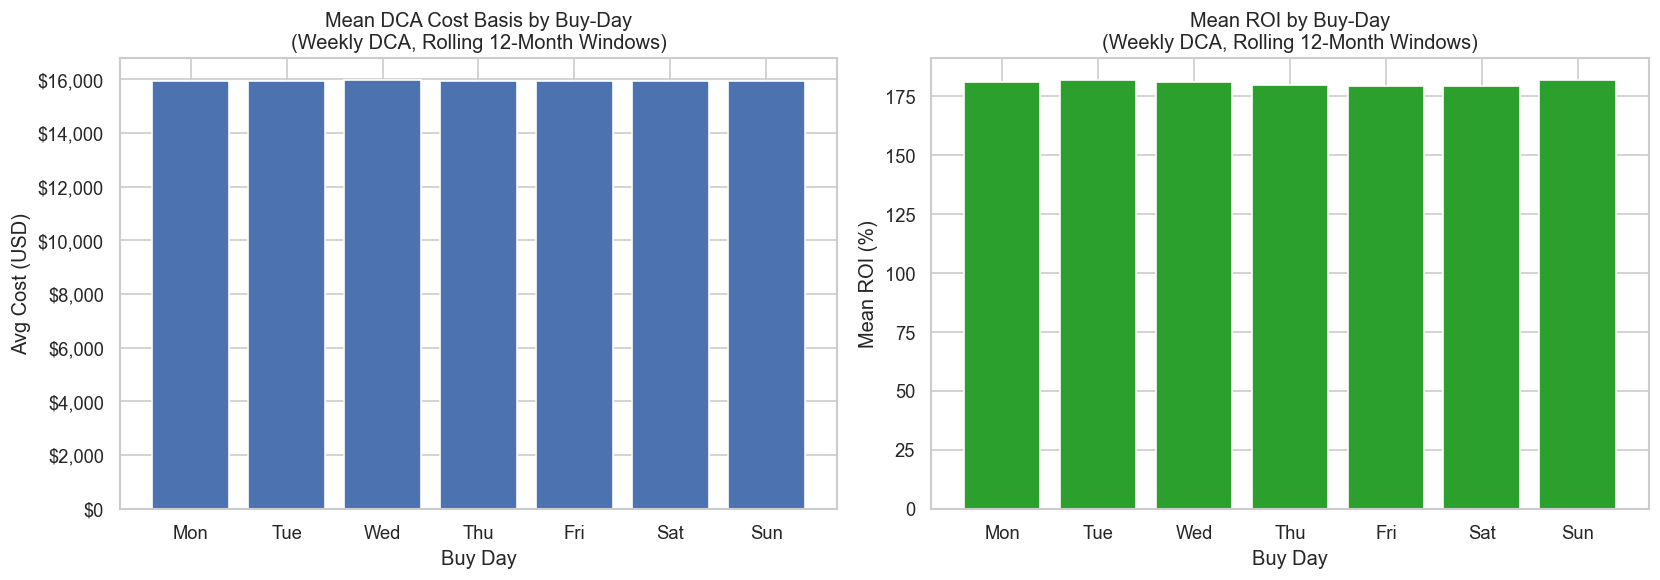

Saved weekday_dca_effect.png



buy_weekday,mean_avg_cost,median_avg_cost,std_avg_cost,mean_roi,median_roi,day_name
i64,f64,f64,f64,f64,f64,str
1,15952.214651,5308.771233,23700.417631,181.032173,44.024436,"""Mon"""
2,15933.696699,5324.790809,23666.648841,181.760129,44.182604,"""Tue"""
3,15984.20079,5364.951117,23769.379091,181.110234,44.846588,"""Wed"""
4,15943.347221,5309.84351,23701.913477,179.80997,43.784008,"""Thu"""
5,15934.98849,5315.374166,23699.129201,179.511685,44.391694,"""Fri"""
6,15939.326063,5342.765442,23700.974966,179.466656,44.002178,"""Sat"""
7,15923.735934,5344.075003,23665.514954,182.013132,43.975489,"""Sun"""


In [8]:
# Simulate weekly DCA for each buy-weekday across all windows
wd_results = []
for start, end in windows:
    for wd in range(1, 8):  # ISO 1=Mon..7=Sun
        r = simulate_dca(btc, start, end, frequency="weekly", buy_weekday=wd)
        if r:
            wd_results.append(r)

wd_df = pl.DataFrame(wd_results)

wd_summary = (
    wd_df
    .group_by("buy_weekday")
    .agg([
        pl.col("avg_cost").mean().alias("mean_avg_cost"),
        pl.col("avg_cost").median().alias("median_avg_cost"),
        pl.col("avg_cost").std().alias("std_avg_cost"),
        pl.col("roi_pct").mean().alias("mean_roi"),
        pl.col("roi_pct").median().alias("median_roi"),
    ])
    .sort("buy_weekday")
    .with_columns(
        pl.col("buy_weekday").replace_strict(WEEKDAY_LABELS).alias("day_name")
    )
)

wd_s_pdf = wd_summary.to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean avg cost by weekday
axes[0].bar(wd_s_pdf["day_name"], wd_s_pdf["mean_avg_cost"], color="#4c72b0")
axes[0].set_title("Mean DCA Cost Basis by Buy-Day\n(Weekly DCA, Rolling 12-Month Windows)")
axes[0].set_ylabel("Avg Cost (USD)")
axes[0].set_xlabel("Buy Day")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

# Mean ROI by weekday
colors = ["#2ca02c" if v >= 0 else "#d62728" for v in wd_s_pdf["mean_roi"]]
axes[1].bar(wd_s_pdf["day_name"], wd_s_pdf["mean_roi"], color=colors)
axes[1].axhline(0, color="black", linewidth=0.5)
axes[1].set_title("Mean ROI by Buy-Day\n(Weekly DCA, Rolling 12-Month Windows)")
axes[1].set_ylabel("Mean ROI (%)")
axes[1].set_xlabel("Buy Day")

plt.tight_layout()
plt.savefig(PLOTS_DIR / "weekday_dca_effect.png", bbox_inches="tight")
plt.show()
print("Saved weekday_dca_effect.png")
print()
wd_summary

## 8. Monthly Seasonality

Compute average daily BTC returns grouped by calendar month across the full history. Months with lower (or negative) average returns may represent better buying opportunities for accumulation.

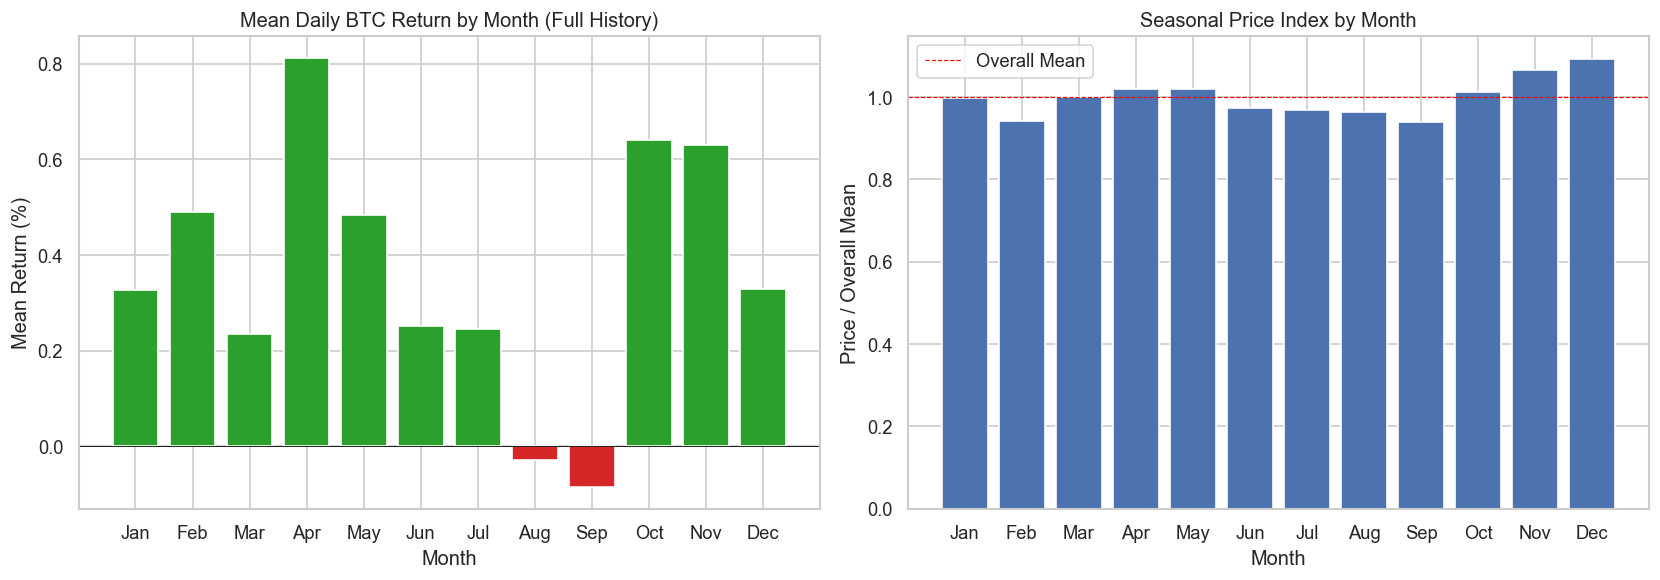

Saved monthly_seasonality.png



month_name,mean_return,median_return,std_return,price_index,n
str,f64,f64,f64,f64,u32
"""Jan""",0.003276,0.00293,0.048197,0.997331,478
"""Feb""",0.004907,0.001204,0.044849,0.94236,424
"""Mar""",0.002338,0.000904,0.044487,0.999582,465
"""Apr""",0.008125,0.002946,0.060336,1.018267,450
"""May""",0.00483,0.002812,0.047797,1.018839,465
…,…,…,…,…,…
"""Aug""",-0.00028,-0.001058,0.045453,0.962363,496
"""Sep""",-0.000853,-0.000088,0.034004,0.940313,480
"""Oct""",0.006399,0.002205,0.041972,1.010994,496


In [9]:
btc_ret = btc.filter(pl.col("daily_return").is_not_null())

monthly_stats = (
    btc_ret
    .group_by("month")
    .agg([
        pl.col("daily_return").mean().alias("mean_return"),
        pl.col("daily_return").std().alias("std_return"),
        pl.col("daily_return").median().alias("median_return"),
        pl.col("PriceUSD").mean().alias("mean_price"),
        pl.len().alias("n"),
    ])
    .sort("month")
    .with_columns(
        pl.col("month").replace_strict(MONTH_LABELS).alias("month_name")
    )
)

# Seasonal price index: each month's mean price vs overall mean
overall_mean_price = btc_ret["PriceUSD"].mean()
monthly_stats = monthly_stats.with_columns(
    (pl.col("mean_price") / overall_mean_price).alias("price_index")
)

mo_pdf = monthly_stats.to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean daily return by month
colors = ["#2ca02c" if v >= 0 else "#d62728" for v in mo_pdf["mean_return"]]
axes[0].bar(mo_pdf["month_name"], mo_pdf["mean_return"] * 100, color=colors)
axes[0].axhline(0, color="black", linewidth=0.5)
axes[0].set_title("Mean Daily BTC Return by Month (Full History)")
axes[0].set_ylabel("Mean Return (%)")
axes[0].set_xlabel("Month")

# Price index
axes[1].bar(mo_pdf["month_name"], mo_pdf["price_index"], color="#4c72b0")
axes[1].axhline(1.0, color="red", linestyle="--", linewidth=0.7, label="Overall Mean")
axes[1].set_title("Seasonal Price Index by Month")
axes[1].set_ylabel("Price / Overall Mean")
axes[1].set_xlabel("Month")
axes[1].legend()

plt.tight_layout()
plt.savefig(PLOTS_DIR / "monthly_seasonality.png", bbox_inches="tight")
plt.show()
print("Saved monthly_seasonality.png")
print()
monthly_stats.select(["month_name", "mean_return", "median_return", "std_return", "price_index", "n"])

## 9. Day-of-Month Effects

Group historical BTC prices by day-of-month (1-31) and compute the average deviation from the monthly mean price. Days with consistently negative deviations may offer cheaper entry points.

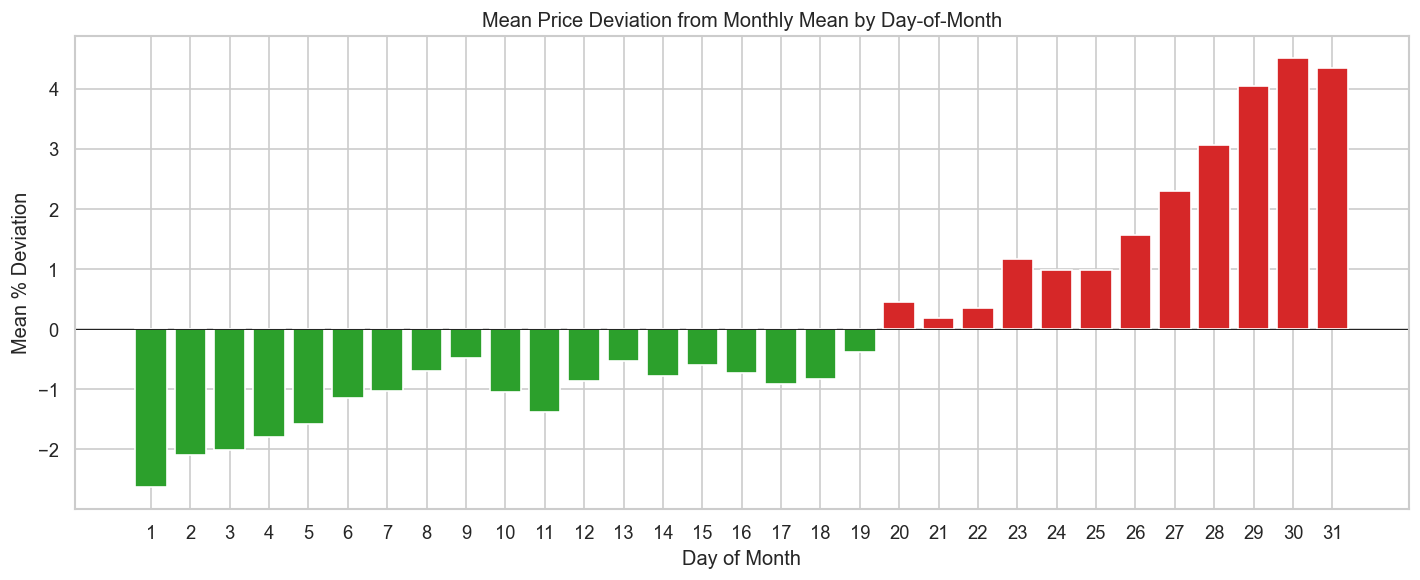

Saved day_of_month_effect.png

Green bars = below monthly average (cheaper). Red = above.


day_of_month,mean_pct_dev,median_pct_dev,std_pct_dev,n
i8,f64,f64,f64,u32
1,-2.630343,-2.674062,14.712303,186
2,-2.090409,-1.953127,14.75331,186
3,-2.019636,-1.735575,14.083966,186
4,-1.792057,-1.572299,13.677525,186
5,-1.582374,-1.368749,13.077975,186
…,…,…,…,…
27,2.290782,0.808917,13.172767,186
28,3.058504,0.645109,14.373298,186
29,4.035497,0.86689,17.705835,175


In [10]:
# Compute monthly mean price, then deviation per day-of-month
btc_with_monthly_mean = btc.with_columns(
    pl.col("PriceUSD").mean().over(["year", "month"]).alias("monthly_mean_price")
).with_columns(
    ((pl.col("PriceUSD") - pl.col("monthly_mean_price")) / pl.col("monthly_mean_price") * 100)
    .alias("pct_dev_from_monthly_mean")
)

dom_stats = (
    btc_with_monthly_mean
    .filter(pl.col("pct_dev_from_monthly_mean").is_not_null())
    .group_by("day_of_month")
    .agg([
        pl.col("pct_dev_from_monthly_mean").mean().alias("mean_pct_dev"),
        pl.col("pct_dev_from_monthly_mean").median().alias("median_pct_dev"),
        pl.col("pct_dev_from_monthly_mean").std().alias("std_pct_dev"),
        pl.len().alias("n"),
    ])
    .sort("day_of_month")
)

dom_pdf = dom_stats.to_pandas()

fig, ax = plt.subplots(figsize=(12, 5))
colors = ["#2ca02c" if v < 0 else "#d62728" for v in dom_pdf["mean_pct_dev"]]
ax.bar(dom_pdf["day_of_month"], dom_pdf["mean_pct_dev"], color=colors)
ax.axhline(0, color="black", linewidth=0.5)
ax.set_title("Mean Price Deviation from Monthly Mean by Day-of-Month")
ax.set_xlabel("Day of Month")
ax.set_ylabel("Mean % Deviation")
ax.set_xticks(range(1, 32))
plt.tight_layout()
plt.savefig(PLOTS_DIR / "day_of_month_effect.png", bbox_inches="tight")
plt.show()
print("Saved day_of_month_effect.png")
print("\nGreen bars = below monthly average (cheaper). Red = above.")
dom_stats.head(31)

## 10. Optimal Purchase Window Heatmap (Weekday × Month)

A 2D heatmap where rows = weekday and columns = month. Each cell shows the mean daily return for that combination. Cells with lower (negative) returns represent periods where buying tends to be cheaper.

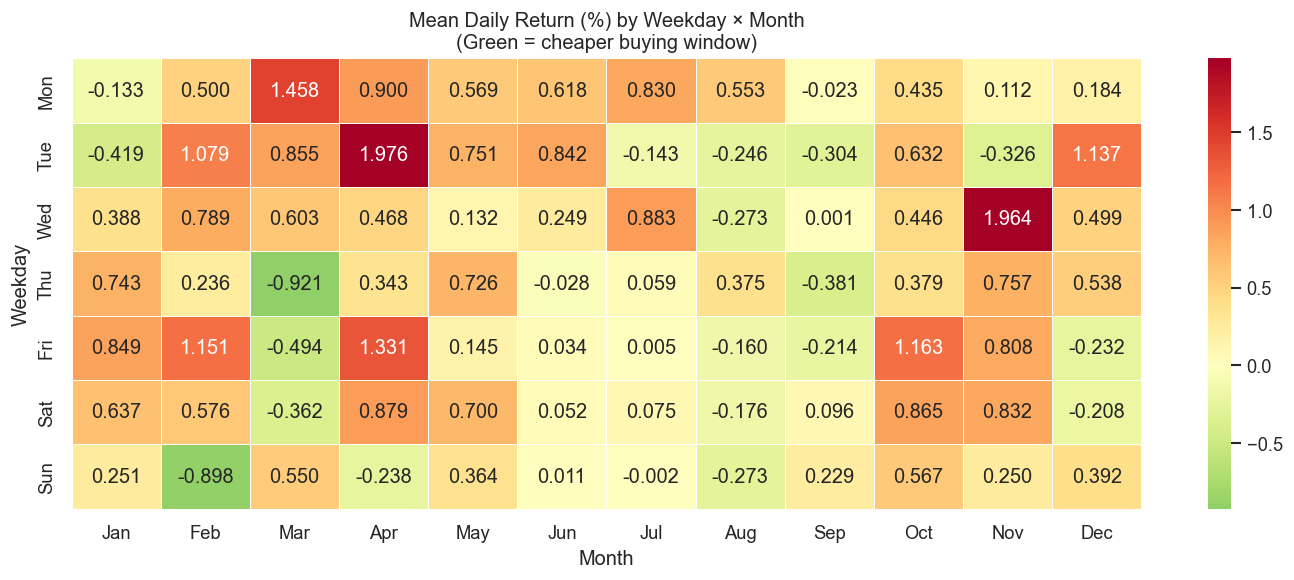

Saved weekday_month_heatmap.png


In [11]:
# Pivot: mean daily return for each (weekday, month) pair
heatmap_data = (
    btc_ret
    .group_by(["weekday", "month"])
    .agg(pl.col("daily_return").mean().alias("mean_return"))
    .sort(["weekday", "month"])
)

# Reshape to matrix
heatmap_pdf = heatmap_data.to_pandas()
pivot = heatmap_pdf.pivot(index="weekday", columns="month", values="mean_return") * 100

# Rename axes
pivot.index = [WEEKDAY_LABELS.get(i, i) for i in pivot.index]
pivot.columns = [MONTH_LABELS.get(c, c) for c in pivot.columns]

fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn_r",  # red = high return (expensive), green = low (cheap to buy)
    center=0,
    linewidths=0.5,
    ax=ax,
)
ax.set_title("Mean Daily Return (%) by Weekday × Month\n(Green = cheaper buying window)")
ax.set_ylabel("Weekday")
ax.set_xlabel("Month")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "weekday_month_heatmap.png", bbox_inches="tight")
plt.show()
print("Saved weekday_month_heatmap.png")

## 11. Statistical Significance Testing

Test whether weekday and monthly effects on daily returns are statistically significant using the Kruskal-Wallis H-test (non-parametric, does not assume normality).

> **Note:** Even a statistically significant result may have very small practical effect size. We report both p-values and eta-squared ($\eta^2$) effect size.

In [12]:
def kruskal_wallis_test(df: pl.DataFrame, group_col: str, value_col: str, labels: dict) -> None:
    """Run Kruskal-Wallis test and report results."""
    groups = []
    group_names = []
    for g in sorted(df[group_col].unique().to_list()):
        vals = df.filter(pl.col(group_col) == g)[value_col].drop_nulls().to_list()
        if len(vals) > 0:
            groups.append(vals)
            group_names.append(labels.get(g, str(g)))

    stat, p_value = stats.kruskal(*groups)
    n = sum(len(g) for g in groups)
    k = len(groups)
    # Eta-squared approximation for Kruskal-Wallis
    eta_sq = (stat - k + 1) / (n - k)

    print(f"Kruskal-Wallis H-test for '{group_col}' effect on '{value_col}':")
    print(f"  H-statistic : {stat:.4f}")
    print(f"  p-value     : {p_value:.6f}  {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else '(not significant)'}")
    print(f"  η² (effect) : {eta_sq:.6f}  ({'negligible' if eta_sq < 0.01 else 'small' if eta_sq < 0.06 else 'medium' if eta_sq < 0.14 else 'large'})")
    print(f"  Groups (k)  : {k}  |  Total obs (n): {n:,}")
    print()

# --- Weekday effect ---
kruskal_wallis_test(btc_ret, "weekday", "daily_return", WEEKDAY_LABELS)

# --- Month effect ---
kruskal_wallis_test(btc_ret, "month", "daily_return", MONTH_LABELS)

# --- Day-of-month effect ---
kruskal_wallis_test(
    btc_with_monthly_mean.filter(pl.col("pct_dev_from_monthly_mean").is_not_null()),
    "day_of_month",
    "pct_dev_from_monthly_mean",
    {d: str(d) for d in range(1, 32)},
)

Kruskal-Wallis H-test for 'weekday' effect on 'daily_return':
  H-statistic : 8.7630
  p-value     : 0.187352  (not significant)
  η² (effect) : 0.000489  (negligible)
  Groups (k)  : 7  |  Total obs (n): 5,658

Kruskal-Wallis H-test for 'month' effect on 'daily_return':
  H-statistic : 15.0579
  p-value     : 0.179864  (not significant)
  η² (effect) : 0.000719  (negligible)
  Groups (k)  : 12  |  Total obs (n): 5,658

Kruskal-Wallis H-test for 'day_of_month' effect on 'pct_dev_from_monthly_mean':
  H-statistic : 68.4642
  p-value     : 0.000078  ***
  η² (effect) : 0.006834  (negligible)
  Groups (k)  : 31  |  Total obs (n): 5,659



## 12. Purchase Timing Summary & Interpretation

This analysis examined **174 rolling 12-month windows** spanning from July 2010 to December 2025 (the full history with valid BTC price data), testing whether purchase *frequency* or *timing* meaningfully improves Bitcoin accumulation efficiency under a fixed $10/event budget.

---

### Key Findings

#### 1. Frequency (Daily vs Weekly vs Biweekly) => Negligible Difference
| Frequency | Mean ROI | Median ROI | Mean Avg Cost |
|-----------|----------|------------|---------------|
| **Biweekly** | 185.0% | 45.0% | $15,891 |
| **Weekly** | 181.0% | 44.0% | $15,952 |
| **Daily** | 180.7% | 44.1% | $15,944 |

All three frequencies produce nearly identical outcomes across all 174 windows. The spread in mean ROI is only ~4 percentage points, which is well within the standard deviation (~657%). **The choice of daily, weekly, or biweekly cadence does not significantly affect long-term accumulation outcomes.**

#### 2. Weekday Buy-Day Effects => Statistically Insignificant
- **Best day:** Sunday (mean avg cost $15,924, mean ROI 182.0%)
- **Worst day:** Wednesday (mean avg cost $15,984, mean ROI 181.1%)
- **Spread:** Only **0.38%** between best and worst day
- **Kruskal-Wallis test:** H = 8.76, **p = 0.187 (not significant)**, η² = 0.0005 (negligible effect size)

There is **no statistically significant weekday effect** on BTC daily returns. The day of the week you choose to buy has essentially no impact on your cost basis over a 12-month horizon.

#### 3. Monthly Seasonality => Statistically Insignificant
- **Strongest months:** April (+0.81% mean daily return), October (+0.64%), November (+0.63%)
- **Weakest months:** September (−0.09%), August (−0.03%)
- **Kruskal-Wallis test:** H = 15.06, **p = 0.180 (not significant)**, η² = 0.0007 (negligible)

While the well-known "September effect" (negative mean returns) and "Q4 rally" (Oct–Nov positive) are visible in the data, **these patterns are not statistically significant** when tested across the full history. The high variance in BTC daily returns (~4–6% std) dwarfs the monthly mean differences.

#### 4. Day-of-Month Effects => Statistically Significant but Negligible effect size
- **Kruskal-Wallis test:** H = 68.46, **p = 0.00008 (significant)***, η² = 0.007 (negligible effect size)

While day-of-month shows statistical significance (likely driven by the large sample size of 5,659 observations), the actual effect size is negligible. The price deviations from monthly mean are tiny and not economically meaningful.

---

### Interpretation and Next Steps

1. **DCA's core strength is confirmed:** The systematic discipline of DCA is far more important than fine-tuning when or how often you buy based on time alone (time of week, month, season). Across 15+ years of BTC history and 174 windows, no timing decisions reliably beat simple DCA.

2. **Next step is to investigate on-chain valuation signals:** Determine if a Dynamic DCA based on on-chain valuation signals could be an optimal strategy over standard DCA.